<a href="https://colab.research.google.com/github/Hubert26/suicides_IPPAN/blob/main/suicides.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Liblaries and settings

In [2]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

#Ustawienie braku maksymalnej ilości wyświetlanych kolumn
pd.options.display.max_columns = None

np.random.seed(42)

#Function definitions

In [35]:
def display_info(df, selected_columns):
    print(selected_columns)
    print(len(selected_columns))
    for col_name in selected_columns:

        # Mode
        print("\nMode:")
        print(df[col_name].mode())

        # NaN count
        nan_count = df[col_name].isna().sum()
        print("\nNaN count:", nan_count)

        # Unique values len
        print("\nUnique values len:")
        print(len(df[col_name].unique()))

        # Unique values
        print("\nUnique values:")
        print(df[col_name].unique())

        # Value counts
        print("\nValue counts:")
        print(df[col_name].value_counts())

        print("\n" + "=" * 40)  # Separator between columns


In [70]:
def create_bar_plot(data, x_label, y_label, title, x_rotation=0):
        # Sprawdzenie czy data jest obiektem Series czy DataFrame
    if isinstance(data, pd.Series):
        # Jeśli indeksy są etykietami kategorii, resetujemy indeksy
        if isinstance(data.index, pd.Index):
            data = data.reset_index()
            x_values = data.iloc[:, 0]  # Pierwsza kolumna po zresetowaniu indeksów
            y_values = data.iloc[:, 1]  # Druga kolumna po zresetowaniu indeksów
        else:
            x_values = data.index  # Używamy indeksów jako wartości x
            y_values = data.values  # Używamy wartości jako wartości y
    elif isinstance(data, pd.DataFrame):
        x_values = data.iloc[:, 0]  # Pierwsza kolumna DataFrame jako wartości x
        y_values = data.iloc[:, 1]  # Druga kolumna DataFrame jako wartości y
    else:
        raise ValueError("Nieobsługiwany typ danych. Oczekiwano obiektu Series lub DataFrame.")

    # Tworzenie wykresu słupkowego
    plt.bar(x_values, y_values)

    # Dodanie tytułu i etykiet osi
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)

    # Wyświetlenie wykresu
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

#Data exploration

In [3]:
df_raw = pd.read_csv('https://raw.githubusercontent.com/Hubert26/suicides_IPPAN/main/data/df_data.csv', delimiter=',', low_memory=False)

In [4]:
df_raw.head()

,suicide_id,report_date_year,report_date_month,age_group,gender,marital_status,education,work_study_info,livelihood_source,is_fatal,location_of_attack,method_of_committing,consciousness_state,substance_info,treatment_info,"reasons_of_attack_Bullying, cyberbullying, harassment",reasons_of_attack_Chronic illness,reasons_of_attack_Committing a crime or misdemeanor,reasons_of_attack_Conflict with non-family members,reasons_of_attack_Death of a close person,reasons_of_attack_Deterioration or sudden loss of health,reasons_of_attack_Family misunderstanding/family violence,"reasons_of_attack_HIV carrier, AIDS patient",reasons_of_attack_Love affair,reasons_of_attack_Mental illness/mental disorders,reasons_of_attack_Other unspecified,reasons_of_attack_Permanent disability,reasons_of_attack_Physical illness,reasons_of_attack_Poor economic conditions/debt,reasons_of_attack_School or work problems,reasons_of_attack_Sudden loss of livelihood,reasons_of_attack_Threat or loss of housing,reasons_of_attack_Unwanted pregnancy,reason_of_attack_count
0,114 581 552,2013,1,NaN,male,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,114 584 284,2013,1,13-18,male,NaN,NaN,Student,NaN,1.0,Road/street/sidewalk,Throwing oneself under a moving vehicle,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,114 584 293,2013,1,13-18,female,Single,Primary education,Student,Dependent on another person,1.0,Other,Jumping from a height,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,114 584 312,2013,1,19-24,male,Single,NaN,NaN,NaN,1.0,NaN,Other,NaN,NaN,NaN,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
4,114 584 399,2013,1,40-44,male,Single,NaN,Unemployed,NaN,1.0,Outbuildings,Hanging,Under the influence of alcohol,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [5]:
df_data = df_raw.copy()

In [6]:
columns_to_drop = [
    'reasons_of_attack_Bullying, cyberbullying, harassment',
    'reasons_of_attack_Chronic illness',
    'reasons_of_attack_Committing a crime or misdemeanor',
    'reasons_of_attack_Conflict with non-family members',
    'reasons_of_attack_Death of a close person',
    'reasons_of_attack_Deterioration or sudden loss of health',
    'reasons_of_attack_Family misunderstanding/family violence',
    'reasons_of_attack_HIV carrier, AIDS patient',
    'reasons_of_attack_Love affair',
    'reasons_of_attack_Mental illness/mental disorders',
    'reasons_of_attack_Other unspecified',
    'reasons_of_attack_Permanent disability',
    'reasons_of_attack_Physical illness',
    'reasons_of_attack_Poor economic conditions/debt',
    'reasons_of_attack_School or work problems',
    'reasons_of_attack_Sudden loss of livelihood',
    'reasons_of_attack_Threat or loss of housing',
    'reasons_of_attack_Unwanted pregnancy'
]

df_data = df_data.drop(columns=columns_to_drop)

In [7]:
df_data['reason_of_attack_count'] = df_data['reason_of_attack_count'].replace(0, np.nan)

##NaN exploration in variables

In [8]:
df_data.shape

(113196, 16)

In [9]:
df_data[df_data['suicide_id'].duplicated()].suicide_id #Sprawdzenie duplikatów

Series([], Name: suicide_id, dtype: object)

In [10]:
##Brakujące dane
total = df_data.isnull().sum().sort_values(ascending=False)
percent = 100*(df_data.isnull().sum()/df_data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

In [11]:
missing_data

,Total,Percent
treatment_info,108281,95.657974
substance_info,93753,82.823598
education,77929,68.844305
consciousness_state,58827,51.969151
work_study_info,55930,49.409873
livelihood_source,49338,43.586346
reason_of_attack_count,40058,35.388176
marital_status,14345,12.672709
age_group,1288,1.137849
location_of_attack,106,0.093643


##NaN exploration in rows

In [12]:
nan_counts = df_data.isna().sum(axis=1).value_counts()

In [13]:
full_index = list(range(0, len(df_data.columns.tolist()) + 1))

# Zsumowanie istniejących wartości z pełną listą i ustawienie brakujących wartości na 0
nan_counts = nan_counts.reindex(full_index, fill_value=0)

# Sortowanie wyników rosnąco
nan_counts = nan_counts.sort_index()

In [14]:
nan_counts_proc = (nan_counts / len(df_data)) * 100

In [15]:
missing_data_rows = pd.concat([nan_counts, nan_counts_proc], axis=1, keys=['Total', 'Percent'])
missing_data_rows

,Total,Percent
0,83,0.073324
1,3873,3.421499
2,15283,13.501360
3,19126,16.896357
4,19919,17.596912
5,21450,18.949433
6,17743,15.674582
7,11497,10.156719
8,3882,3.429450
9,263,0.232340


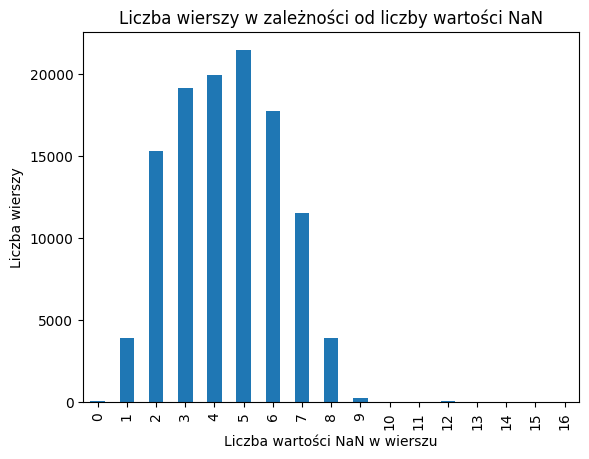

In [16]:
# Tworzenie wykresu kolumnowego
nan_counts.plot(kind='bar')

# Dodanie tytułu i etykiet osi
plt.title('Liczba wierszy w zależności od liczby wartości NaN')
plt.xlabel('Liczba wartości NaN w wierszu')
plt.ylabel('Liczba wierszy')

# Wyświetlenie wykresu
plt.show()

##data_age_group_

In [17]:
data_age_groups = df_data.dropna(subset=['age_group', 'gender']).copy()

In [18]:
sorted(list(set(data_age_groups['age_group'])))


['13-18',
 '19-24',
 '25-29',
 '30-34',
 '35-39',
 '40-44',
 '45-49',
 '50-54',
 '55-59',
 '60-64',
 '65-69',
 '7-12',
 '70-74',
 '75-79',
 '80-84',
 '85+']

###data_age_group_7-12

In [19]:
data_age_group_7_12 = data_age_groups.loc[data_age_groups['age_group'] == '7-12'].copy()

In [20]:
data_age_group_7_12.shape

(343, 16)

####NaN exploration in variables

In [21]:
##Brakujące dane
total = data_age_group_7_12.isnull().sum().sort_values(ascending=False)
percent = 100*(data_age_group_7_12.isnull().sum()/data_age_group_7_12.isnull().count()).sort_values(ascending=False)
missing_data_age_group_7_12 = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

In [22]:
missing_data_age_group_7_12

,Total,Percent
substance_info,343,100.000000
treatment_info,343,100.000000
consciousness_state,120,34.985423
reason_of_attack_count,85,24.781341
education,44,12.827988
livelihood_source,17,4.956268
work_study_info,12,3.498542
marital_status,6,1.749271
suicide_id,0,0.000000
report_date_year,0,0.000000


####NaN exploration in rows

In [72]:
nan_counts = data_age_group_7_12.isna().sum(axis=1).value_counts()

In [73]:
full_index = list(range(0, len(data_age_group_7_12.columns.tolist()) + 1))

# Zsumowanie istniejących wartości z pełną listą i ustawienie brakujących wartości na 0
nan_counts = nan_counts.reindex(full_index, fill_value=0)

# Sortowanie wyników rosnąco
nan_counts = nan_counts.sort_index()

In [25]:
nan_counts_proc = (nan_counts / len(data_age_group_7_12)) * 100

In [26]:
missing_data_rows = pd.concat([nan_counts, nan_counts_proc], axis=1, keys=['Total', 'Percent'])
missing_data_rows

,Total,Percent
0,0,0.000000
1,0,0.000000
2,158,46.064140
3,116,33.819242
4,46,13.411079
5,17,4.956268
6,5,1.457726
7,1,0.291545
8,0,0.000000
9,0,0.000000


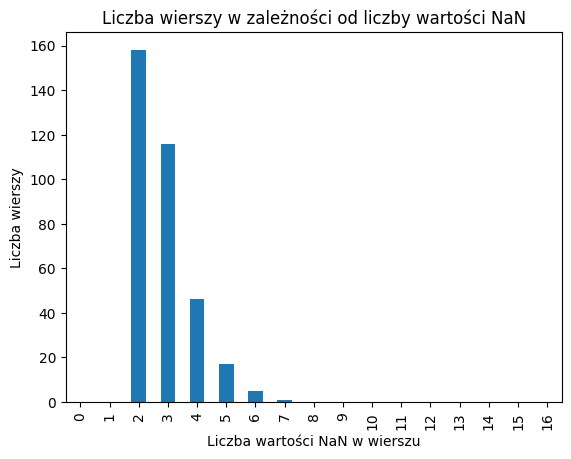

In [27]:
# Tworzenie wykresu kolumnowego
nan_counts.plot(kind='bar')

# Dodanie tytułu i etykiet osi
plt.title('Liczba wierszy w zależności od liczby wartości NaN')
plt.xlabel('Liczba wartości NaN w wierszu')
plt.ylabel('Liczba wierszy')

# Wyświetlenie wykresu
plt.show()

In [75]:
nan_counts.iloc[0] = str(nan_counts.iloc[0])

In [68]:
nan_counts.reset_index()

,index,0
0,0,0
1,1,0
2,2,158
3,3,116
4,4,46
5,5,17
6,6,5
7,7,1
8,8,0
9,9,0


TypeError: 'value' must be an instance of str or bytes, not a int

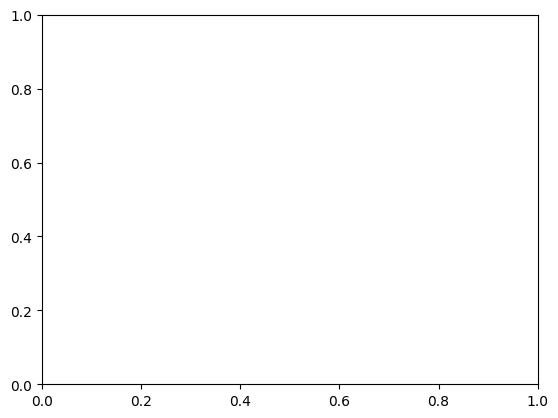

In [76]:
create_bar_plot(nan_counts, 'Liczba wartości NaN w wierszu', 'Liczba wierszy', 'Liczba wierszy w zależności od liczby wartości NaN', x_rotation=45)

####Variable - education

In [36]:
display_info(data_age_group_7_12, ['education'])

['education']
1

Mode:
0    Incomplete primary education
Name: education, dtype: object

NaN count: 44

Unique values len:
4

Unique values:
['Primary education' 'Incomplete primary education' nan
 'Lower secondary education']

Value counts:
Incomplete primary education    194
Primary education               103
Lower secondary education         2
Name: education, dtype: int64



In [67]:
data_age_group_7_12['education'].dropna().value_counts()

Incomplete primary education    226
Primary education               115
Lower secondary education         2
Name: education, dtype: int64

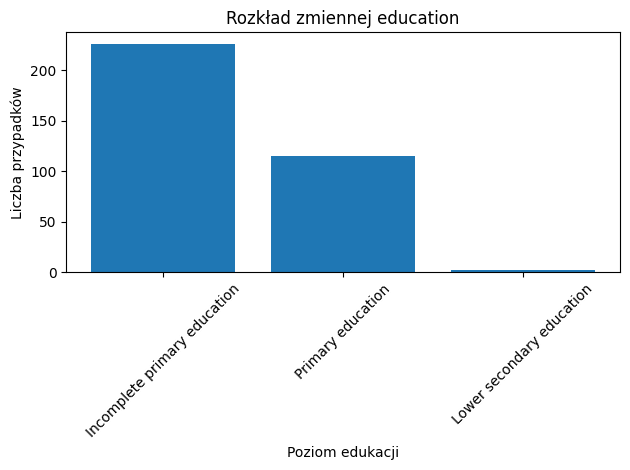

In [55]:
# Usuń wartości NaN z kolumny 'education'
no_nan = data_age_group_7_12['education'].dropna()

# Oblicz liczebność każdej kategorii
value_counts = no_nan.value_counts()

create_bar_plot(data_age_group_7_12['education'].dropna().value_counts(), 'Poziom edukacji', 'Liczba przypadków', 'Rozkład zmiennej education', x_rotation=45)

In [45]:
probabilities = no_nan.value_counts() / len(no_nan)

In [46]:
# Przygotuj wartości NaN do zastąpienia
nan_values = data_age_group_7_12['education'].isnull()

# Wybierz losowo wartości na podstawie prawdopodobieństw
replacement_values = np.random.choice(probabilities.index, size=np.sum(nan_values), p=probabilities.values)

# Zastąp wartości NaN wylosowanymi wartościami
data_age_group_7_12.loc[nan_values, 'education'] = replacement_values


0


In [51]:
display_info(data_age_group_7_12, ['education'])

['education']
1

Mode:
0    Incomplete primary education
Name: education, dtype: object

NaN count: 0

Unique values len:
3

Unique values:
['Primary education' 'Incomplete primary education'
 'Lower secondary education']

Value counts:
Incomplete primary education    226
Primary education               115
Lower secondary education         2
Name: education, dtype: int64



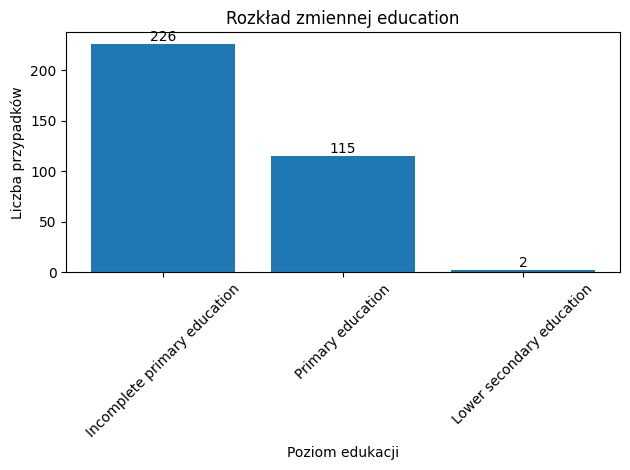

In [57]:
create_bar_plot(data_age_group_7_12['education'].value_counts(), 'Poziom edukacji', 'Liczba przypadków', 'Rozkład zmiennej education', x_rotation=45)